## **Naive approach**

In [512]:
# Installing required libraries

# !pip install xgboost --quiet
# !pip install ipython-autotime  --quiet
# !pip install shap --quiet
# %load_ext autotime

In [513]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

# import gdown

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from itertools import cycle
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from timeit import default_timer as timer
import warnings
from collections import defaultdict

import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

import shap

import random
from scipy import stats

from tqdm import tqdm

In [514]:
shap.initjs() # Initialize SHAP for later

## **Utility functions**

In [515]:
# Utility function for accessing and formating the input dataframes.
# Dataframe df is assumed to be preprocessed already
def get_regression_data(df, target, cols=None, # Target columns
                        tactics=True, embeddings=True, # Flags to select tactic encoding, embeddings encoding, or both
                        split_by_level=True): # If True, the dataset is split into batches (for active learning)
  '''Prepares data for regression tasks.

  This function extracts features and target variables from a dataframe,
  optionally splitting the data into batches for active learning.

  Args:
    df: The input dataframe containing features and target variables.
    target: A list of column names representing the target variables.
    cols: A list of column names to include as features (default: None).
    tactics: A boolean flag indicating whether to include tactic encoding features (default: True).
    embeddings: A boolean flag indicating whether to include embeddings encoding features (default: True).
    split_by_level: A boolean flag indicating whether to split the data into batches based on the 'level' column (default: True).

  Returns:
    A tuple containing:
      - X_list: A list of feature matrices, or a single feature matrix if split_by_level is False.
      - y_list: A list of target variable arrays, or a single target variable array if split_by_level is False.
      - fnames: A list of feature names.
  '''

  if cols is None:
    cols = target
  temp = df.columns
  cols = cols+['solID']
  for t in target:
    if t in cols:
      cols.remove(t)
  if 'bot' in temp:
    cols.append('bot')
  if not tactics:
    tactic_cols = [c for c in temp if c.startswith('op')]
    for c in tactic_cols:
      cols.append(c)
  if not embeddings:
    emb_cols = [c for c in temp if c.startswith('emb')]
    for c in emb_cols:
      cols.append(c)

  X = df.drop(cols, axis=1)
  if len(target) == 1:
    y = df[target[0]]
  else:
    y = df[target]

  if split_by_level:
    levels = set(X['level'])
    X_list = []
    y_list = []
    for l in levels:
      #print(l)
      df_level = X[X['level'] == l]
      X_list.append(df_level.drop(['level']+target, axis=1).values)
      y_list.append(df_level[target].values)
  else:
    X_list = X.drop(['level']+target, axis=1).values
    if len(target) == 1:
      y_list = X[target[0]].values
    else:
      y_list = X[target].values

  fnames = list(X.columns)
  fnames.remove('level')
  for t in target:
    fnames.remove(t)

  return X_list, y_list, fnames

# Divides a column (or range) in n bins
def get_bins(col, n, min_max=(None,None)):
    """Divides a column into bins.

    This function divides a column (or range) into n bins.
    It calculates the bin edges based on the unique values in the column
    and the specified number of bins.

    Args:
        col: The column (pandas Series) to be divided into bins.
        n: The number of bins to create.
        min_max: Tuple (min, max) representing the minimum and maximum values
                 for the bins. If None, the minimum and maximum values of the
                 column are used (default: (None, None)).

    Returns:
        A list of bin edges.
    """

    unique_values = sorted((set(col.values)))
    if min_max == (None,None):
        min_x = np.min(unique_values)
        max_x = np.max(unique_values)
    else:
        print("Using predefined limits",min_max)
        min_x = min_max[0]
        max_x = min_max[1]
    min_x = min_x - 0.1
    max_x = max_x + 0.1
    delta = (max_x - min_x)/n
    #print(min_x, max_x, delta)
    return ([min_x+i*delta for i in range(0,n)] + [max_x])

# Utility function for plotting the distribution of the quality-attribute objectives (regression targets)
def plot_outcome_distribution(df_outcomes, n_bins=100, labels=5, filename=None, mins_maxs=(None,None),
                              colors=['blue', 'red', 'green', 'orange'], figsize=(8,8)):
    """Plots the distribution of quality-attribute objectives.

    This function creates a histogram to visualize the distribution of
    quality-attribute objectives (regression targets) in a given dataframe.
    It allows for customization of the number of bins, labels, and colors.
    The plot can be saved to a file if a filename is provided.

    Args:
        df_outcomes: Dataframe containing the quality-attribute objectives.
        n_bins: The number of bins for the histogram (default: 100).
        labels: The number of labels to display on the x-axis (default: 5).
        filename: The filename to save the plot to (default: None).
        mins_maxs: A list or tuple of (min, max) values to define the range of the x-axis for each subplot. If None, the minimum and maximum values of the column are used (default: (None, None)).
        colors: A list of colors to use for the histograms (default: ['blue', 'red', 'green', 'orange']).
        figsize: The size of the figure (default: (8, 8)).
    """

    qas = list(df_outcomes.columns)

    fig, axs = plt.subplots(len(qas), 1, sharey=True, tight_layout=True, figsize=figsize)
    for idx, qa in enumerate(qas):
        col = df_outcomes[qa]
        min_max = (None,None)
        if mins_maxs != (None,None):
            min_max = mins_maxs[idx]
            #print(min_max)
        col_range = get_bins(col, labels, min_max)
        print(qa, col_range)
        if min_max != (None,None):
            col = col.tolist()
            col.append(min_max[0])
            col.append(min_max[1])
        axs[idx].hist(col, bins=n_bins, color=colors[idx])
        axs[idx].set_title(qa)
        for xc in col_range:
            axs[idx].axvline(x=xc, color='gray', linestyle='dashed')

    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [516]:
def compute_regression_metrics(y, y_pred):
  """Computes regression metrics.

  This function calculates common regression metrics to evaluate the
  performance of a regression model.

  Args:
      y: The true target values.
      y_pred: The predicted target values.

  Returns:
      A dictionary containing the computed metrics:
          - R2: R-squared (coefficient of determination)
          - MSE: Mean squared error
          - RMSE: Root mean squared error
          - MAE: Mean absolute error
          - MAPE: Mean absolute percentage error
  """

  metrics = dict()

  metrics['R2'] = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  metrics['MSE'] = mse
  metrics['RMSE'] = np.sqrt(mse)
  metrics['MAE'] = mean_absolute_error(y, y_pred)
  metrics['MAPE'] = mean_absolute_percentage_error(y, y_pred)

  return metrics

# Creates a grid of charts showing the prediction errors of a regression (actual versus predicted values)
# The charts also include some regression metrics (e.g., R2, RMSE, MAE, MAPE)
# Optionally, specific values can be marked with stars (e.g., for distinguishing the sub-sampling strategy)
# Plots can be saved to a file
def show_prediction_errors_multioutput(y, y_pred, target, colors=['blue'], y_query=None, y_query_pred=None,
                                       metrics=True, x=1, verbose=True, title=None,
                                       gridsize=(1,4), errors=None, filename=None):
  """Creates a grid of charts showing prediction errors for multi-output regression.

    This function visualizes the prediction errors of a regression model with
    multiple output variables. It displays actual vs. predicted values using
    scatter plots and includes regression metrics like R2, RMSE, MAE, and MAPE.
    Optionally, it can highlight specific data points and save the plots to a file.

    Args:
        y: The true target values (NumPy array).
        y_pred: The predicted target values (NumPy array).
        target: A list of target variable names.
        colors: A list of colors for the scatter plots (default: ['blue']).
        y_query: Optional true target values for specific data points to highlight (default: None).
        y_query_pred: Optional predicted target values for specific data points to highlight (default: None).
        metrics: A boolean flag indicating whether to display regression metrics (default: True).
        verbose: A boolean flag indicating whether to print detailed metrics (default: True).
        title: An optional title for the plot (default: None).
        gridsize: A tuple specifying the number of rows and columns in the plot grid (default: (1, 4)).
        errors: Optional error bars for highlighted data points (default: None).
        filename: An optional filename to save the plot to (default: None).
  """

  for idx, n in enumerate(target):
    if verbose:
      print("-->", n)
      metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])
      for m in metrics.keys():
        print(m+"=", metrics[m])
  if verbose:
    print()

  n = len(target)
  fig, axs = plt.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(4*gridsize[1], 4*gridsize[0]))
  for idx, n in enumerate(target):
    if len(colors) == 1:
      c = colors[0]
    else:
      c = colors[idx]
    j = idx % gridsize[1]
    i = idx // gridsize[1]
    #print("ax:", idx, i, j)
    if gridsize[0] == 1:
      ax = axs[j]
    else:
      ax = axs[i][j]
    PredictionErrorDisplay.from_predictions(
      y_true=y[:,idx],
      y_pred=y_pred[:,idx],
      kind="actual_vs_predicted",
      subsample=None,
      ax=ax, #axs[idx], #ax=axs[0][idx],
      random_state=0, scatter_kwargs={"alpha": 0.5, "color": c}
    )

    ax.set_title(n)
    if y_query is not None:
      if errors is not None:
        ax.errorbar(y_query_pred[:,idx], y_query[:,idx], yerr=errors, fmt="o", ecolor="gray", capsize=3, alpha=0.5)
      ax.scatter(y_query_pred[:,idx], y_query[:,idx], c='red', marker='*', s=80, alpha=0.5)

    # Add the score in the legend of each axis
    metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])

    r2_patch = mpatches.Patch(color='none', label='R2='+str(round(metrics['R2'], 2)))
    rmse_patch = mpatches.Patch(color='none', label='RMSE='+str(round(metrics['RMSE'], 2)))
    mae_patch = mpatches.Patch(color='none', label='MAE='+str(round(metrics['MAE'], 2)))
    mape_patch = mpatches.Patch(color='none', label='MAPE='+str(round(metrics['MAPE'], 2)))
    m_patches = [r2_patch, rmse_patch, mae_patch, mape_patch]
    if metrics:
      ax.legend(handles=m_patches)

  if filename is not None:
    plt.tight_layout()
    plt.savefig(filename, format='pdf')
  if title is not None:
    fig.suptitle(title)
  if filename is None:
    plt.tight_layout()
  plt.show()

In [517]:
def show_shap_plots(X, fnames, model, targets):
  """Displays SHAP bar plots for feature importance.

  This function utilizes the SHAP (SHapley Additive exPlanations) library to
  calculate and visualize the importance of features in a prediction model.
  It generates bar plots showing the impact of each feature on the model's output.

  Args:
      X: The input data (NumPy array or Pandas DataFrame).
      fnames: A list of feature names corresponding to the columns in X.
      model: The trained prediction model.
      targets: A list of target variable names.
  """

  df = pd.DataFrame(X, columns=fnames)
  explainer = shap.Explainer(model)
  shap_values = explainer(df)
  for i in range(shap_values.shape[2]):  # If shap_values is for multiple outputs
    print("Target:", targets[i])
    output_shap_values = shap_values[:, :, i]
    shap.plots.bar(output_shap_values, max_display=15)

## **Load datasets**

In [518]:
# Datasets are assumed to be already pre-processed/encoded
STPLUS_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/stplus-levels-bots-features.csv'
COCOME_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/cocome-levels-features.csv'

OBJ_STPLUS= ['m1', 'm2', 'p1', 'p2']
OBJ_COCOME = ['m1', 'm2', 'm3', 'm4','p1', 'p2', 'p3', 'p4']

# print(gdown.download(STPLUS_URL, STPLUS_DATAPATH, quiet=True))
# print(gdown.download(COCOME_URL, COCOME_DATAPATH, quiet=True))

In [519]:
df_stplus = pd.read_csv(STPLUS_DATAPATH, index_col=0)
print(df_stplus.shape)
df_stplus.head() # raw ST+ dataset

(454, 741)


,solID,m1,m2,p1,p2,level,bot,op1_mod-split(PaymentSystem)-wrapper(IBooking),op1_mod-split(PaymentSystem)-wrapper(IBusinessTrip),op1_mod-split(PaymentSystem)-wrapper(IEmployeePayment),...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_270,115.0,291.5,24.37365,29.9622,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_81,119.0,110.5,14.12836,21.8758,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_103,115.0,190.5,18.76987,33.9213,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_508,119.0,231.5,16.93228,26.7557,2,Performance,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_182,115.0,190.5,21.48976,26.6179,2,Modifiability,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [520]:
df_cocome = pd.read_csv(COCOME_DATAPATH, index_col=0)
print(df_cocome.shape)
df_cocome # raw CoCoME dataset

(1192, 929)


,solID,m1,m2,m3,m4,p1,p2,p3,p4,level,...,emb_490_0,emb_491_0,emb_492_0,emb_493_0,emb_494_0,emb_495_0,emb_496_0,emb_497_0,emb_498_0,emb_499_0
0,sol-arch_1004,2218.0,727.0,137.5,2172.5,0.897089,1.071037,1.025776,1.901695,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sol-arch_401,2333.0,750.5,161.0,2216.5,1.298680,1.550426,1.706878,2.576643,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sol-arch_137,2262.0,731.5,142.0,2216.5,0.976805,1.124319,1.214135,1.853881,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sol-arch_453,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sol-arch_404,2333.0,798.0,208.5,2216.5,1.052553,1.226608,1.160202,2.045067,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,sol-arch_1174,2289.0,802.5,204.0,2172.5,0.832682,0.937078,1.117719,1.435772,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1188,sol-arch_187,2289.0,802.5,181.0,2172.5,1.233312,1.676923,1.305529,3.288065,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1189,sol-arch_674,2289.0,802.5,208.5,2172.5,0.965911,1.173523,0.926582,2.053899,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,sol-arch_821,2261.0,730.5,142.0,2215.5,1.031333,1.187748,1.737787,2.023827,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [521]:
# Show distribution of quality-attribute objectives for ST+
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_stplus_df = pd.DataFrame(scaler.fit_transform(df_stplus[OBJ_STPLUS]), columns=OBJ_STPLUS)
# make_boxplots(scaled_stplus_df, title='STPlus (scaled)', figsize=(400, 900))

In [522]:
# Show distribution of quality-attribute objectives for CoCoME
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_cocome_df = pd.DataFrame(scaler.fit_transform(df_cocome[OBJ_COCOME]), columns=OBJ_COCOME)
# make_boxplots(scaled_cocome_df, title='CoCoME (scaled)', figsize=(400, 1600))

## **Experiments with the full dataset**

In [523]:
def run_cross_validation(regressor, X_batches, y_batches, metrics, cv_nfold=100, scale_y=True):
  
  if scale_y:
    print("Standard scaling y ...", len(y_batches), "batches")
    scaler = StandardScaler()
    for i,_ in enumerate(y_batches):
      y_batches[i] = scaler.fit_transform(y_batches[i])

  results_dict = {}
  for scoring_metric in metrics: # Initialize the dictionaries
      results_dict[scoring_metric] = []
  for i,_ in enumerate(y_batches):
    n =  y_batches[i].shape[0] // cv_nfold
    k_folds = 2 if (n <= 1) else n
    print("kfolds:", k_folds, "(", y_batches[i].shape[0],"instances)")
    for scoring_metric in metrics:
      cross_val_results = cross_val_score(regressor, X_batches[i], y_batches[i], cv=k_folds, scoring=scoring_metric)
      results_dict[scoring_metric] = results_dict[scoring_metric] + list(cross_val_results)

  return results_dict


# It runs the whole dataset as a single batch and applies a RF regressor
def run_single_batch(X, y, regressor, show_plots=None, test_size=0.33, target=None, verbose=True, scale_y=True, levels=None, filename=None):

  """Runs a regression model on a single batch of data.

  This function trains and evaluates a regression model (e.g., RandomForestRegressor, XGBRegressor)
  on a single batch of data. It performs a train-test split, optionally scales the target
  variable, fits the regressor, and visualizes prediction errors. It also calculates and prints
  regression metrics (R2, MSE, RMSE, MAE, MAPE) for both the test set and the whole dataset.

  Args:
      X: The feature matrix.
      y: The target variable array.
      regressor: The regression model to use (e.g., RandomForestRegressor, XGBRegressor).
      show_plots: A tuple specifying the grid size for prediction error plots (e.g., (1, 4)). If None, plots are not shown.
      test_size: The proportion of data to include in the test split (default: 0.33).
      target: A list of target variable names.
      verbose: A boolean flag indicating whether to print detailed metrics (default: True).
      scale_y: A boolean flag indicating whether to scale the target variable using StandardScaler (default: True).
      levels: An optional array-like object to stratify the train-test split based on levels (default: None).
      filename: An optional filename to save the prediction error plots to (default: None).

  Returns:
      A tuple containing:
          - dict_metrics: A dictionary containing the computed regression metrics for the test set and the whole dataset.
          - y_pred: The predicted target values for the whole dataset.
  """

  if levels is not None:
    print("Stratifying on levels ...")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=levels, random_state=42)
  print("Test set sizes:", X_test.shape, y_test.shape)
  print()

  if scale_y:
    scaler = StandardScaler()
    print("Standard scaling for y ...")
    y_train = scaler.fit_transform(y_train)
    y_test = scaler.fit_transform(y_test)
    y = scaler.fit_transform(y)

  mycolors = list(mcolors.TABLEAU_COLORS.keys())
  #colors = [mycolors[x] for x in range(len(target))]
  colors = ['blue']

  dict_metrics = defaultdict(list)
  start = timer()

  regressor.fit(X_train, y_train)
  y_test_pred = regressor.predict(X_test)

  title = "Test set - "+str(X_test.shape)
  show_prediction_errors_multioutput(y_test, y_test_pred, target=target, colors=colors, metrics=True,
                                     title=title, verbose=verbose, gridsize=show_plots, filename=filename)

  # Global metrics
  print()
  print("="*10, "Metrics (test set)")
  #print("Multi RF score=%.2f " % regr_multirf.score(X_test, y_test))
  print("RF score=%.2f " % regressor.score(X_test, y_test))
  metrics = compute_regression_metrics(y_test, y_test_pred)
  dict_metrics['exp'] = dict_metrics['exp'] + ['naive - test set']
  dict_metrics['size'] = dict_metrics['size'] + [X_test.shape[0]]
  dict_metrics['features'] = dict_metrics['features'] + [X_test.shape[1]]
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])
  print("="*10)

  print()
  end = timer()
  elapsed_time = end - start
  print("Elapsed time:", elapsed_time, "seconds") # Time in seconds
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time]

  print()
  y_pred = regressor.predict(X)
  title = "Train+test set - "+str(X.shape)
  show_prediction_errors_multioutput(y, y_pred, target=target, colors=colors, metrics=True,
                                     title=title, verbose=verbose, gridsize=show_plots)
  print()
  print("="*10, "Metrics (whole set)")
  metrics = compute_regression_metrics(y, y_pred)
  dict_metrics['exp'] = dict_metrics['exp'] + ['naive - whole set']
  dict_metrics['size'] = dict_metrics['size'] + [X.shape[0]]
  dict_metrics['features'] = dict_metrics['features'] + [X.shape[1]]
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time]
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])
  print("="*10)

  return dict_metrics, y_pred

In [524]:
# Configuration parameters for ranking the models
cv_nfold = 100
model_performance_dict = {}
scoring_metrics = ['neg_median_absolute_error', 'r2', 'neg_root_mean_squared_error']

### **STPlus results**
Test the 3 available configurations for the encodings, using the naive baseline approach

STPLUS - tactics only
(454, 234) (454, 4)
Stratifying on levels ...
Test set sizes: (227, 234) (227, 4)

Standard scaling for y ...


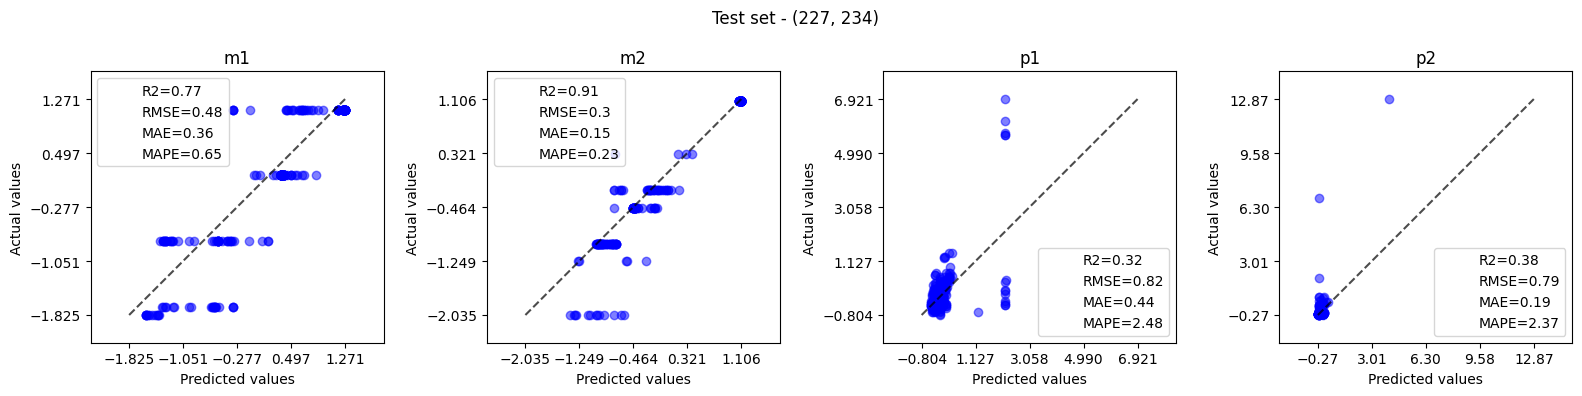


========== Metrics (test set)
RF score=0.60 
R2= 0.595908288190457
MSE= 0.4040917118095435
RMSE= 0.6356820839142342
MAE= 0.2821568488222191
MAPE= 1.4324838140605638

Elapsed time: 0.4059978749137372 seconds



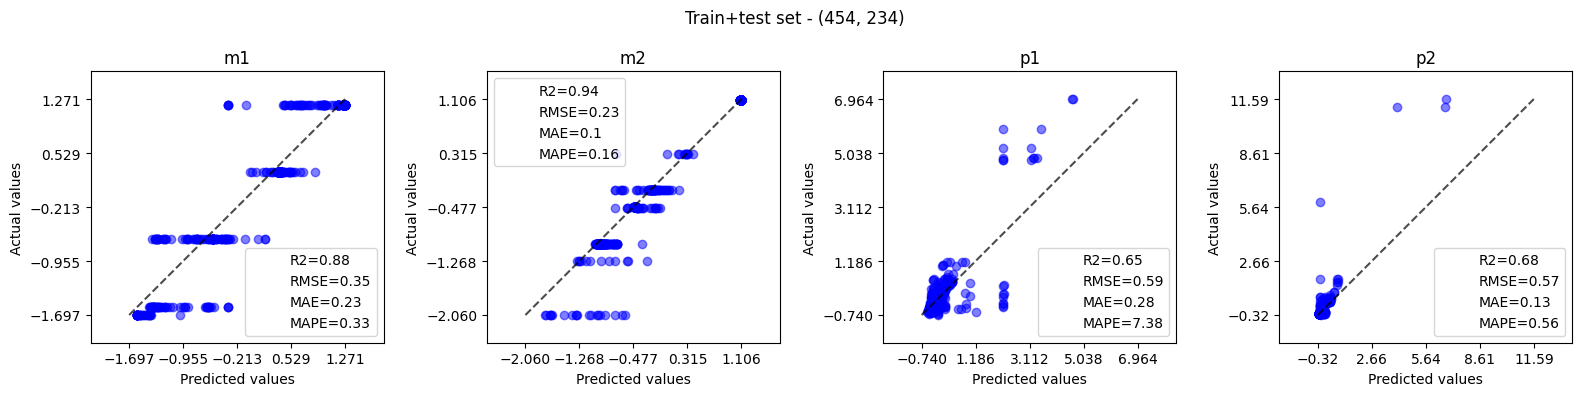


========== Metrics (whole set)
R2= 0.7888724337022595
MSE= 0.21112756629774063
RMSE= 0.459486198158052
MAE= 0.18616976767996585
MAPE= 2.106268393490788
Standard scaling y ... 2 batches
kfolds: 2 ( 30 instances)
kfolds: 4 ( 424 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,227,234,0.595908,0.404092,0.635682,0.282157,1.432484,0.405998
1,naive - whole set,454,234,0.788872,0.211128,0.459486,0.186170,2.106268,0.405998


In [525]:
print("STPLUS - tactics only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=False, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred = run_single_batch(X, y, regressor, target=target, verbose=False, show_plots=(1,4),
                                   test_size=0.5, levels=df_stplus['level'])

X_batches, y_batches, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=False, split_by_level=True)
model_performance_dict['STPLUS - t'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

pd.DataFrame(metrics)

STPLUS - embeddings only
(454, 500) (454, 4)
Stratifying on levels ...
Test set sizes: (227, 500) (227, 4)

Standard scaling for y ...


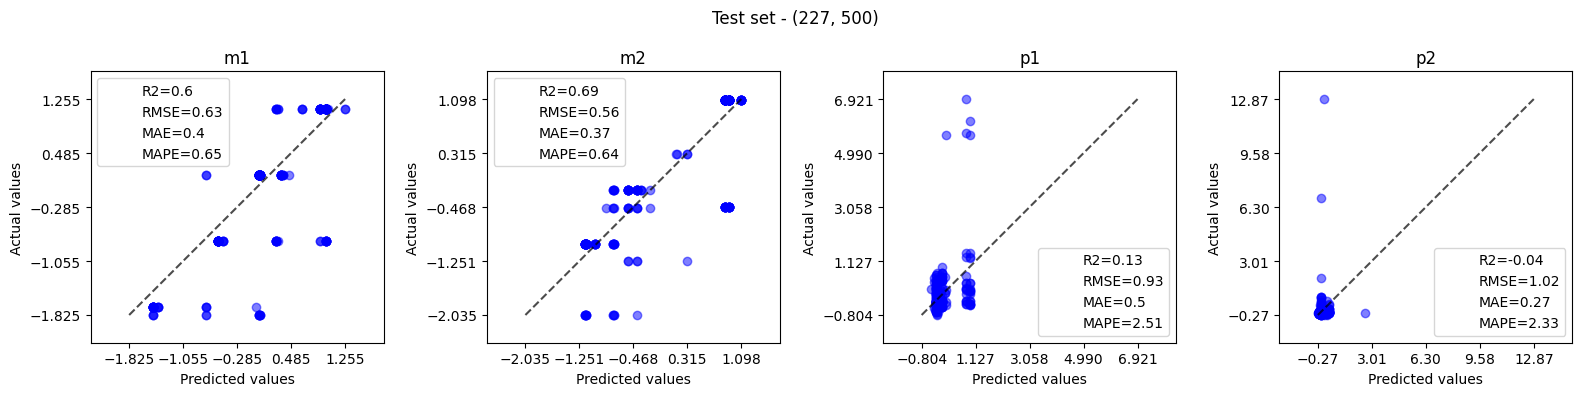


========== Metrics (test set)
RF score=0.34 
R2= 0.3440522871407273
MSE= 0.6559477128592737
RMSE= 0.8099059901366785
MAE= 0.384850973858265
MAPE= 1.5319664213410937

Elapsed time: 0.4580711249727756 seconds



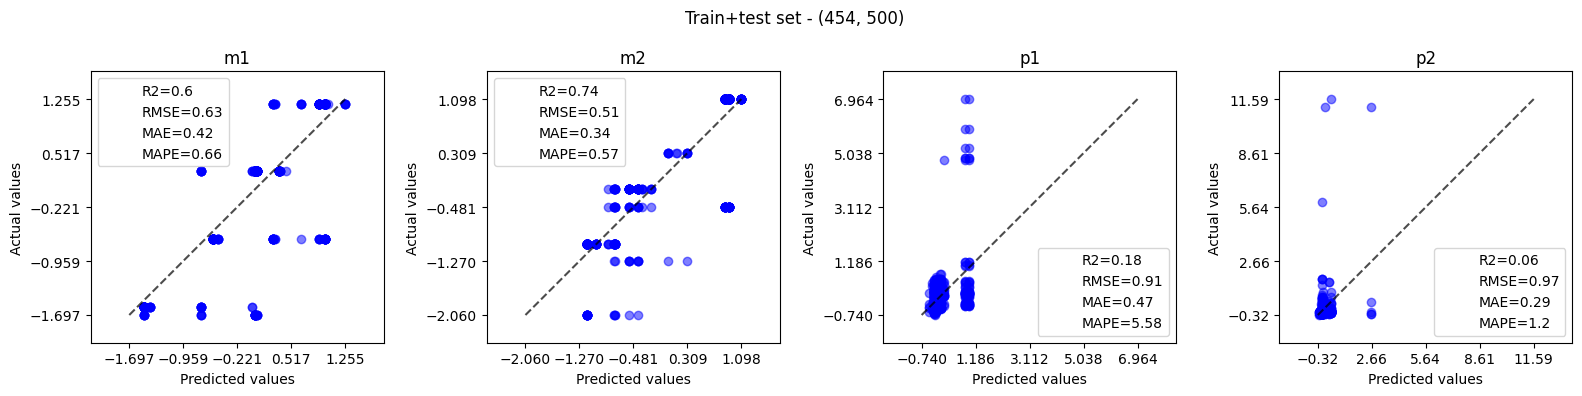


========== Metrics (whole set)
R2= 0.3953327232635262
MSE= 0.6046672767364738
RMSE= 0.7776035472761642
MAE= 0.378885604964832
MAPE= 2.001003956525579
Standard scaling y ... 2 batches
kfolds: 2 ( 30 instances)
kfolds: 4 ( 424 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,227,500,0.344052,0.655948,0.809906,0.384851,1.531966,0.458071
1,naive - whole set,454,500,0.395333,0.604667,0.777604,0.378886,2.001004,0.458071


In [526]:
print("STPLUS - embeddings only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=False, embeddings=True, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred = run_single_batch(X, y, regressor, target=target, verbose=False, show_plots=(1,4),
                                   test_size=0.5, levels=df_stplus['level'])

X_batches, y_batches, _ = get_regression_data(df_stplus, target=target, tactics=False, embeddings=True, split_by_level=True)
model_performance_dict['STPLUS - e'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

pd.DataFrame(metrics)

STPLUS - tactics & embeddings
(454, 734) (454, 4)
Stratifying on levels ...
Test set sizes: (227, 734) (227, 4)

Standard scaling for y ...


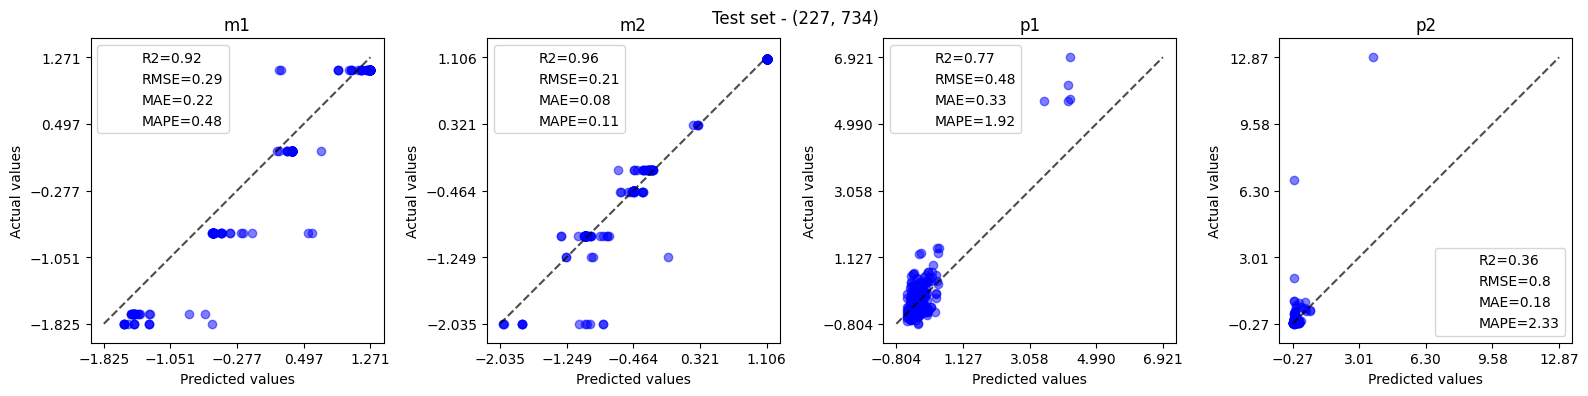


========== Metrics (test set)
RF score=0.75 
R2= 0.7498124263063592
MSE= 0.2501875736936411
RMSE= 0.5001875385229435
MAE= 0.20369236485568912
MAPE= 1.2108069593237198

Elapsed time: 0.9892552918754518 seconds



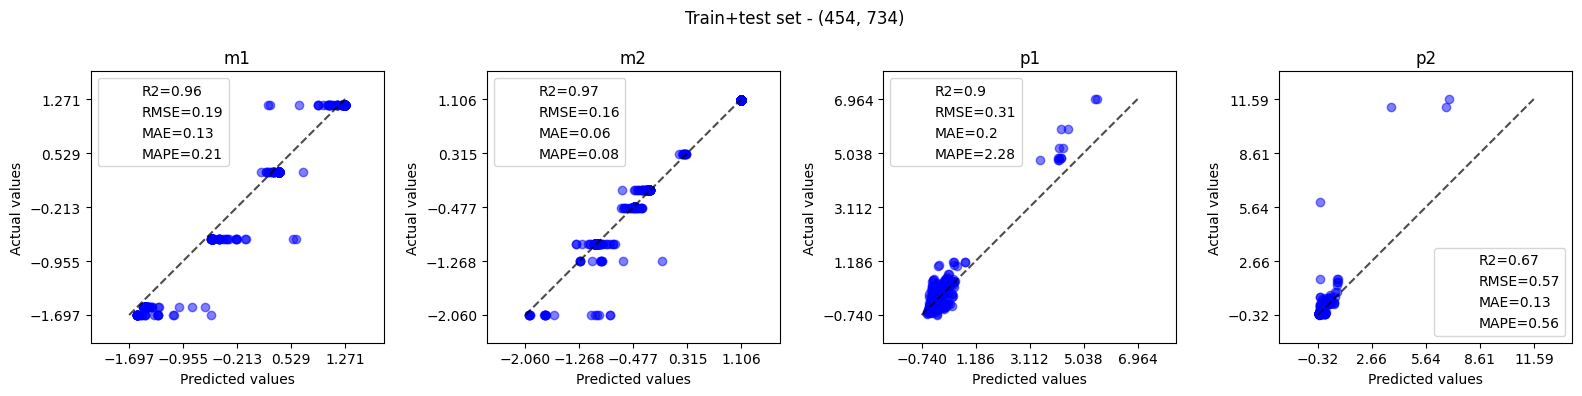


========== Metrics (whole set)
R2= 0.8788855741819684
MSE= 0.1211144258180315
RMSE= 0.3480149793012242
MAE= 0.12827986083753887
MAPE= 0.7803070922402195
Standard scaling y ... 2 batches
kfolds: 2 ( 30 instances)
kfolds: 4 ( 424 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,227,734,0.749812,0.250188,0.500188,0.203692,1.210807,0.989255
1,naive - whole set,454,734,0.878886,0.121114,0.348015,0.128280,0.780307,0.989255


In [527]:
print("STPLUS - tactics & embeddings")
target = OBJ_STPLUS
X, y, fnames = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred_baseline_stplus = run_single_batch(X, y, regressor, target=target, verbose=False, show_plots=(1,4),
                                                   test_size=0.5, filename='stplus-naive-all.pdf', levels=df_stplus['level'])

X_batches, y_batches, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=True)
model_performance_dict['STPLUS - t & e'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

df_baseline_stplus = pd.DataFrame(metrics)
df_baseline_stplus

Target: m1


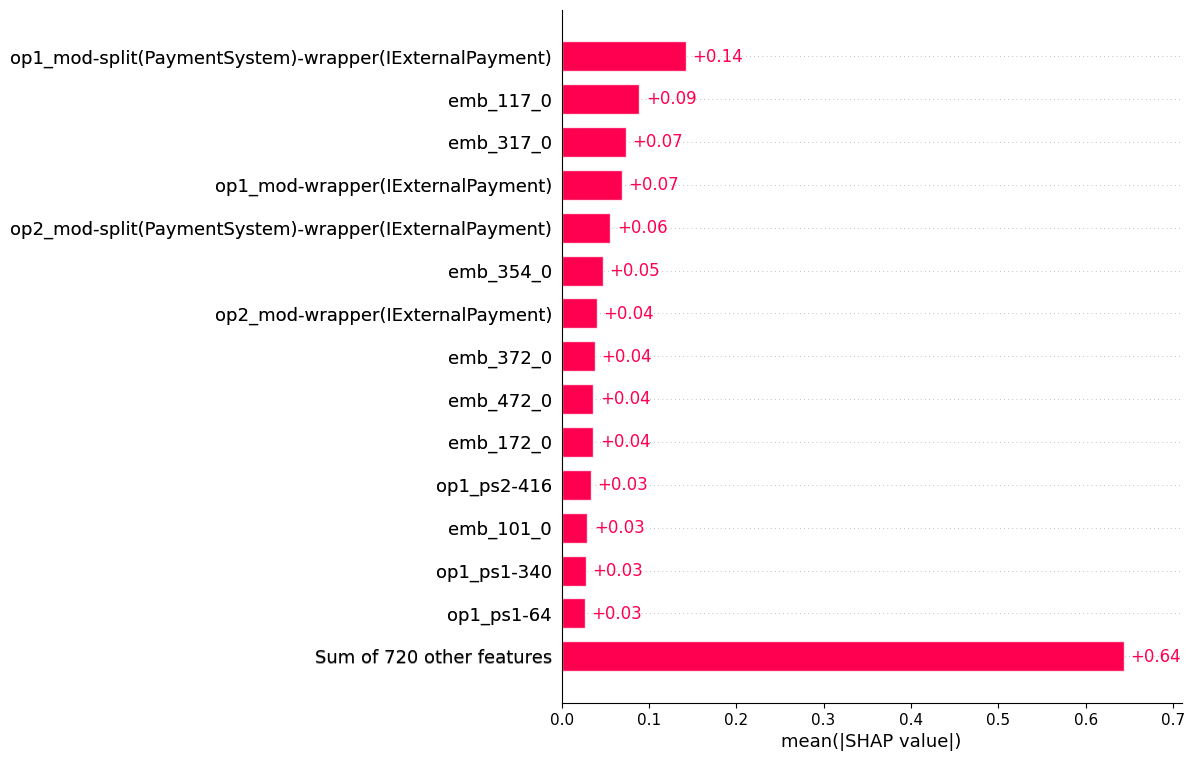

Target: m2


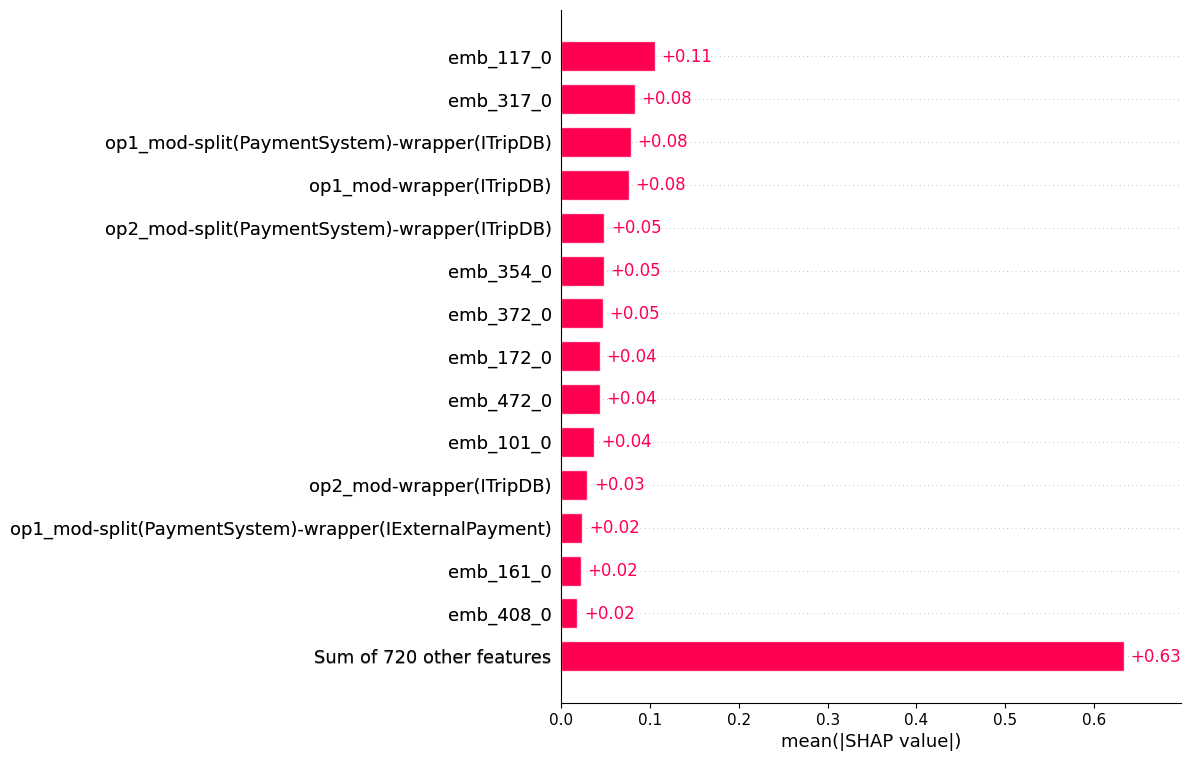

Target: p1


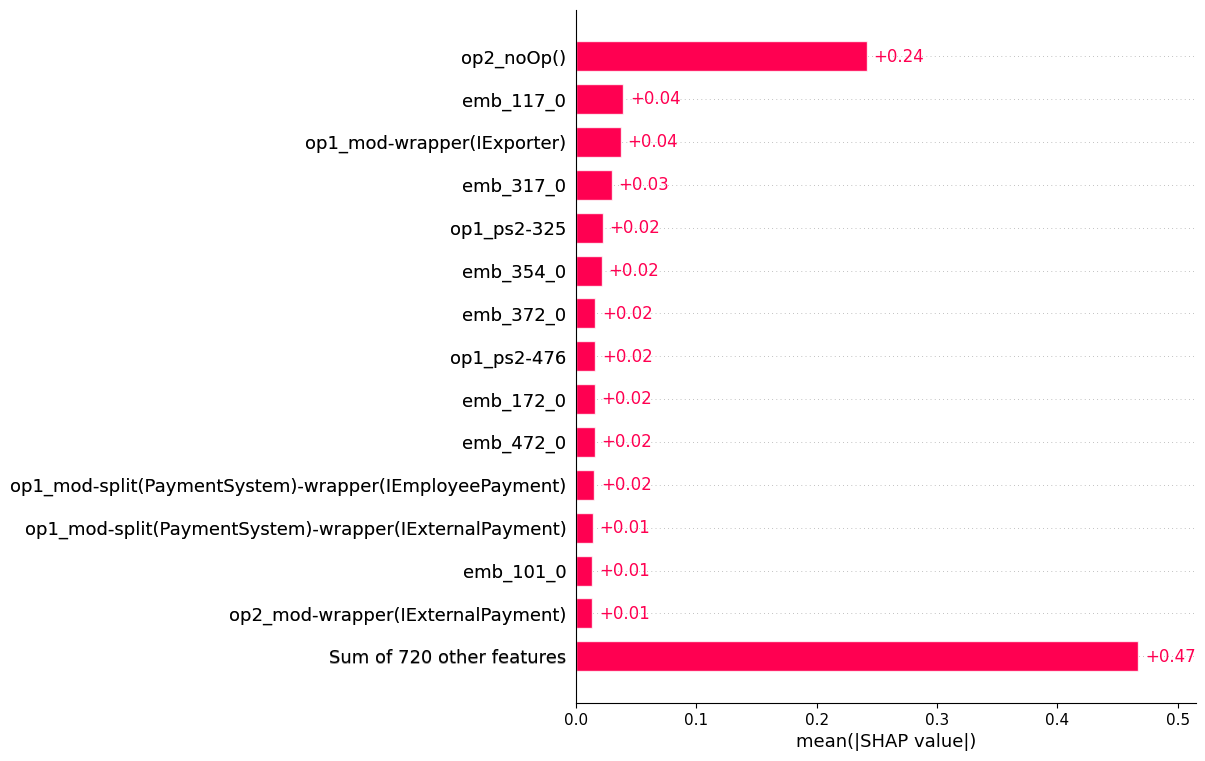

Target: p2


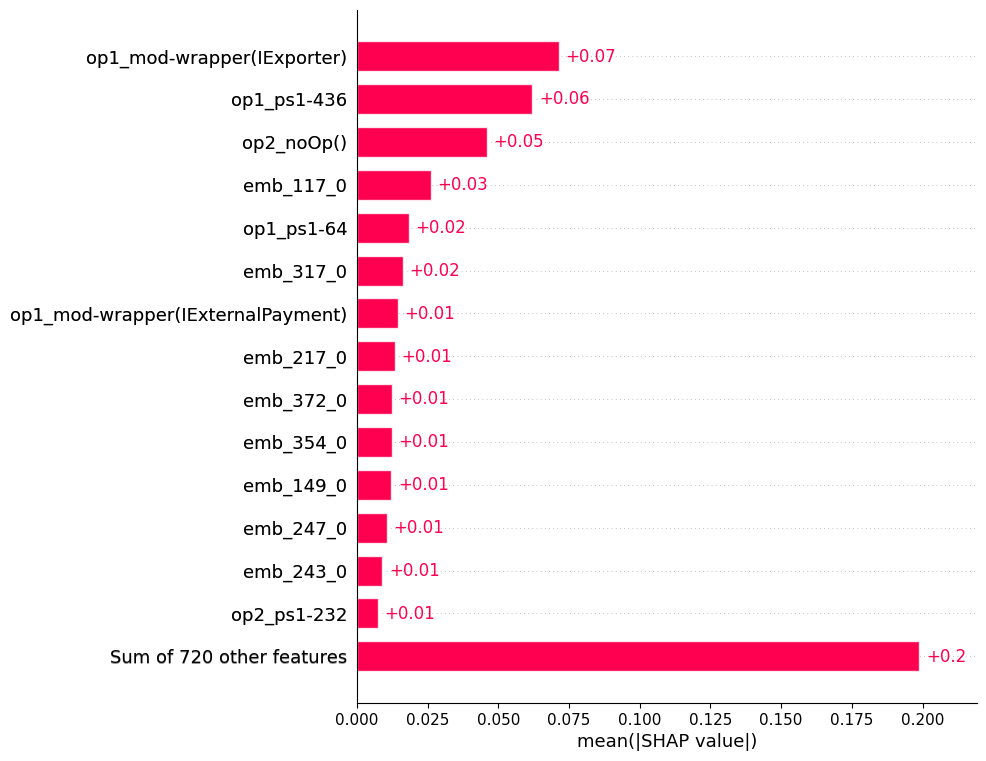

In [528]:
# Show influence of tactics and embeddings via SHAP values/plots
show_shap_plots(X, fnames, regressor, OBJ_STPLUS)

### **COCOME results**
Test the 3 available configurations for the encodings, using the naive baseline approach

COCOME - tactics only
(1192, 419) (1192, 8)
Stratifying on levels ...
Test set sizes: (596, 419) (596, 8)

Standard scaling for y ...


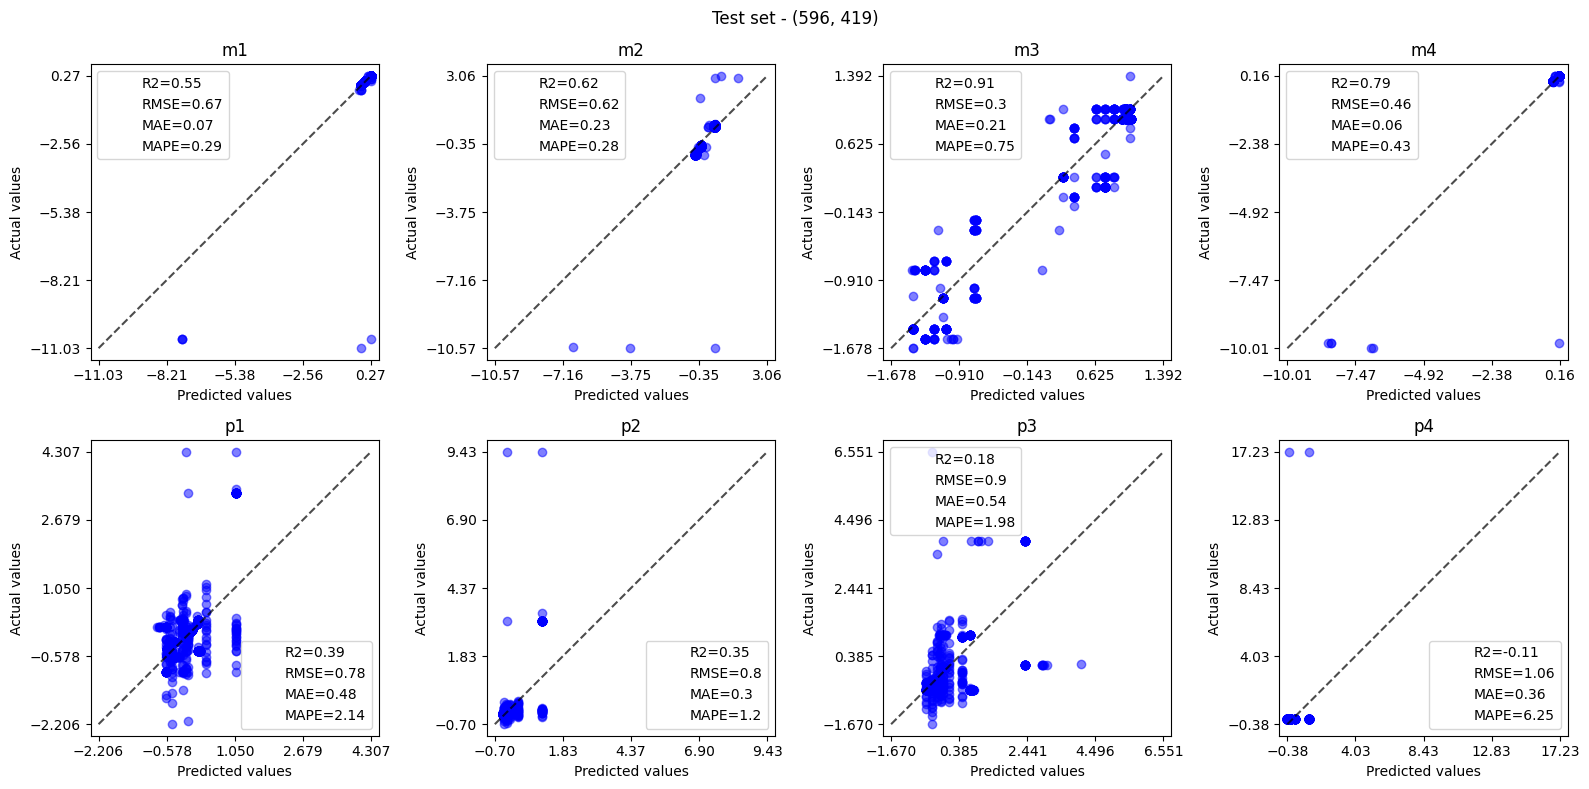


========== Metrics (test set)
RF score=0.46 
R2= 0.46068661455839865
MSE= 0.5393133854416002
RMSE= 0.7343795922011996
MAE= 0.27995462108975566
MAPE= 1.666228209231756

Elapsed time: 0.7258579158224165 seconds



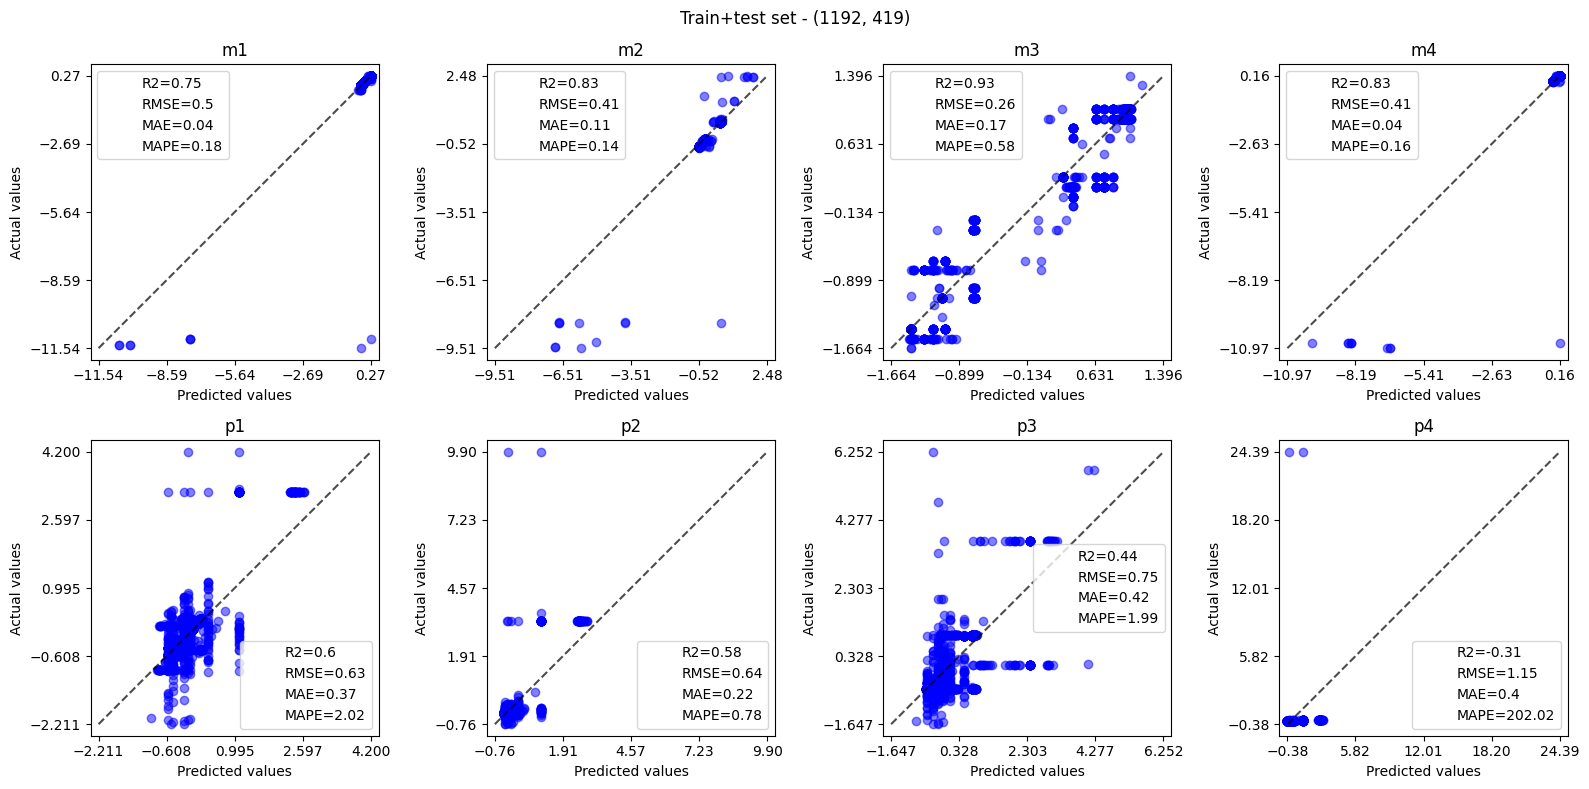


========== Metrics (whole set)
R2= 0.5822039745221954
MSE= 0.4177960254778046
RMSE= 0.6463714299671703
MAE= 0.2214126291701019
MAPE= 25.984260950602977
Standard scaling y ... 5 batches
kfolds: 2 ( 125 instances)
kfolds: 3 ( 344 instances)
kfolds: 3 ( 301 instances)
kfolds: 2 ( 120 instances)
kfolds: 3 ( 302 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,596,419,0.460687,0.539313,0.734380,0.279955,1.666228,0.725858
1,naive - whole set,1192,419,0.582204,0.417796,0.646371,0.221413,25.984261,0.725858


In [529]:
print("COCOME - tactics only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=False, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred = run_single_batch(X, y, regressor, show_plots=(2,4), target=target, verbose=False,
                                   test_size=0.5, levels=df_cocome['level'])

X_batches, y_batches, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=False, split_by_level=True)
model_performance_dict['COCOME - t'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

pd.DataFrame(metrics)

COCOME - embeddings only
(1192, 500) (1192, 8)
Stratifying on levels ...
Test set sizes: (596, 500) (596, 8)

Standard scaling for y ...


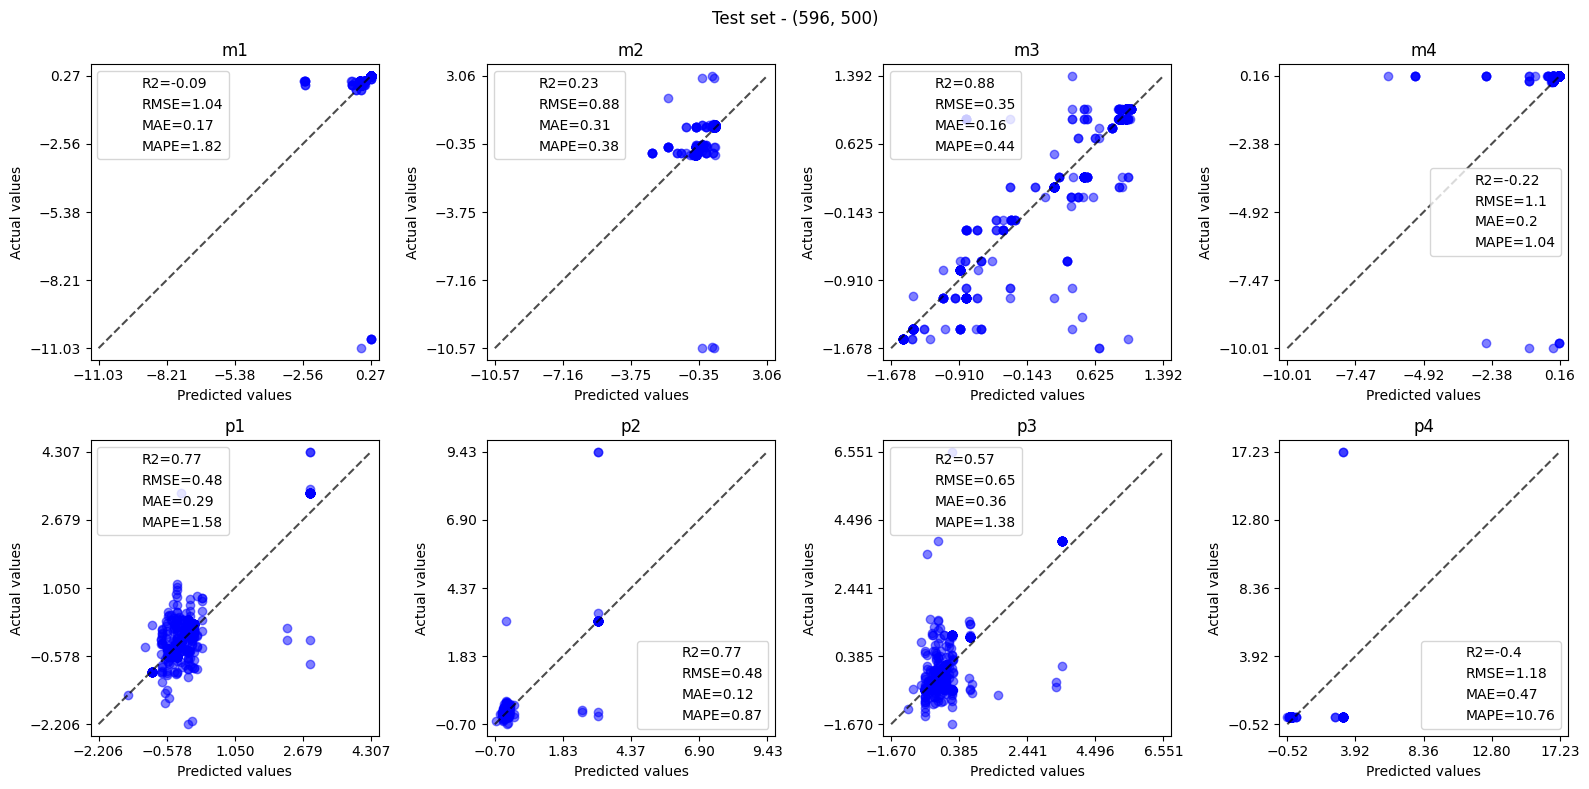


========== Metrics (test set)
RF score=0.31 
R2= 0.31481860520620586
MSE= 0.6851813947937915
RMSE= 0.827756845211075
MAE= 0.26007280313296166
MAPE= 2.2831749023856194

Elapsed time: 1.8821570000145584 seconds



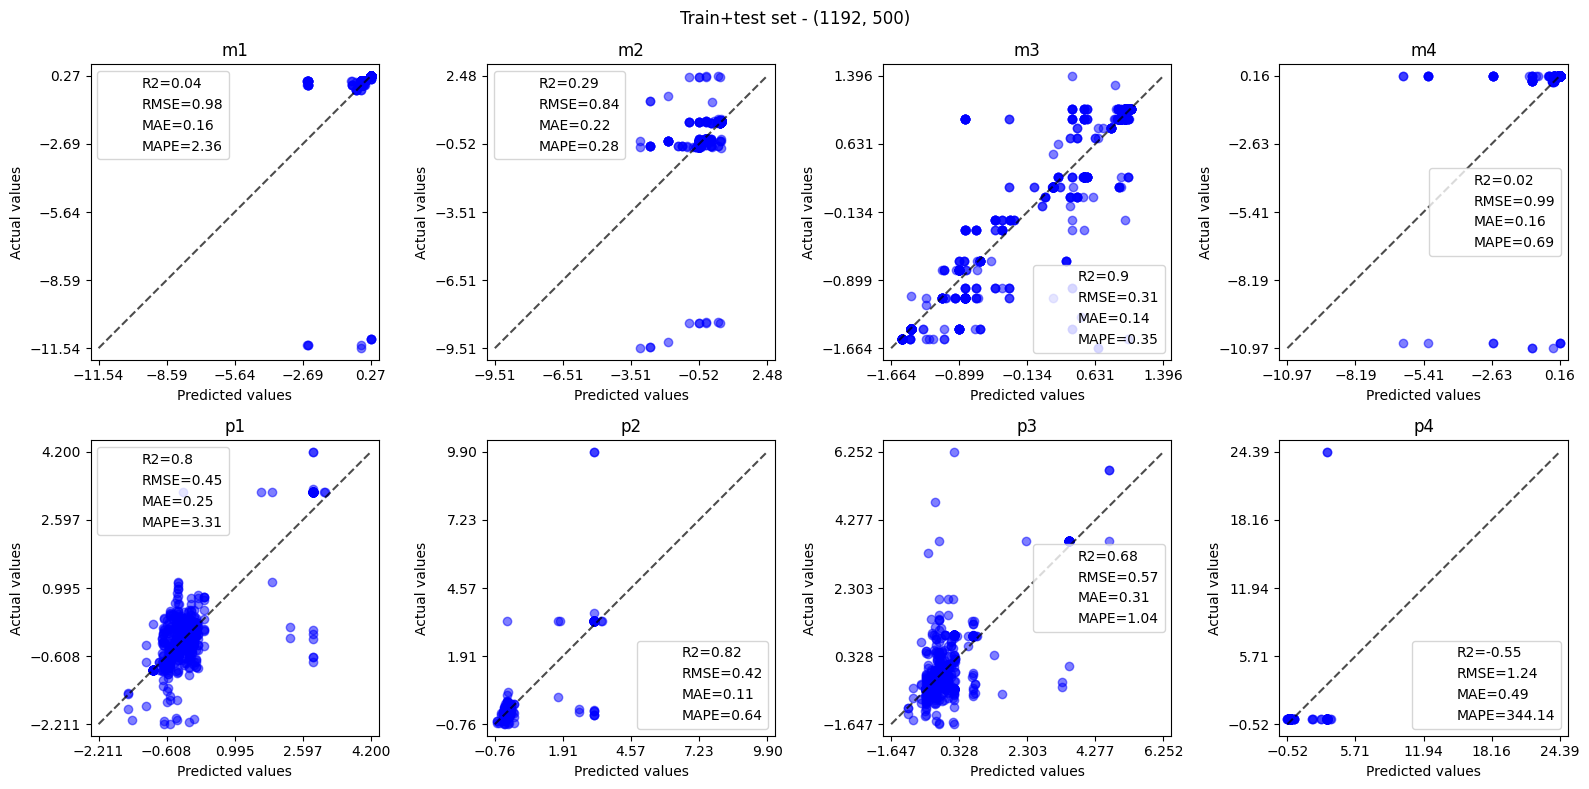


========== Metrics (whole set)
R2= 0.37598623181131063
MSE= 0.6240137681886893
RMSE= 0.789945421018876
MAE= 0.23167293113646126
MAPE= 44.10228177236267
Standard scaling y ... 5 batches
kfolds: 2 ( 125 instances)
kfolds: 3 ( 344 instances)
kfolds: 3 ( 301 instances)
kfolds: 2 ( 120 instances)
kfolds: 3 ( 302 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,596,500,0.314819,0.685181,0.827757,0.260073,2.283175,1.882157
1,naive - whole set,1192,500,0.375986,0.624014,0.789945,0.231673,44.102282,1.882157


In [530]:
print("COCOME - embeddings only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=False, embeddings=True, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred = run_single_batch(X, y, regressor, show_plots=(2,4), target=target, verbose=False,
                                   test_size=0.5, levels=df_cocome['level'])

X_batches, y_batches, _ = get_regression_data(df_cocome, target=target, tactics=False, embeddings=True, split_by_level=True)
model_performance_dict['COCOME - e'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

pd.DataFrame(metrics)

COCOME - tactics & embeddings
(1192, 919) (1192, 8)
Stratifying on levels ...
Test set sizes: (596, 919) (596, 8)

Standard scaling for y ...


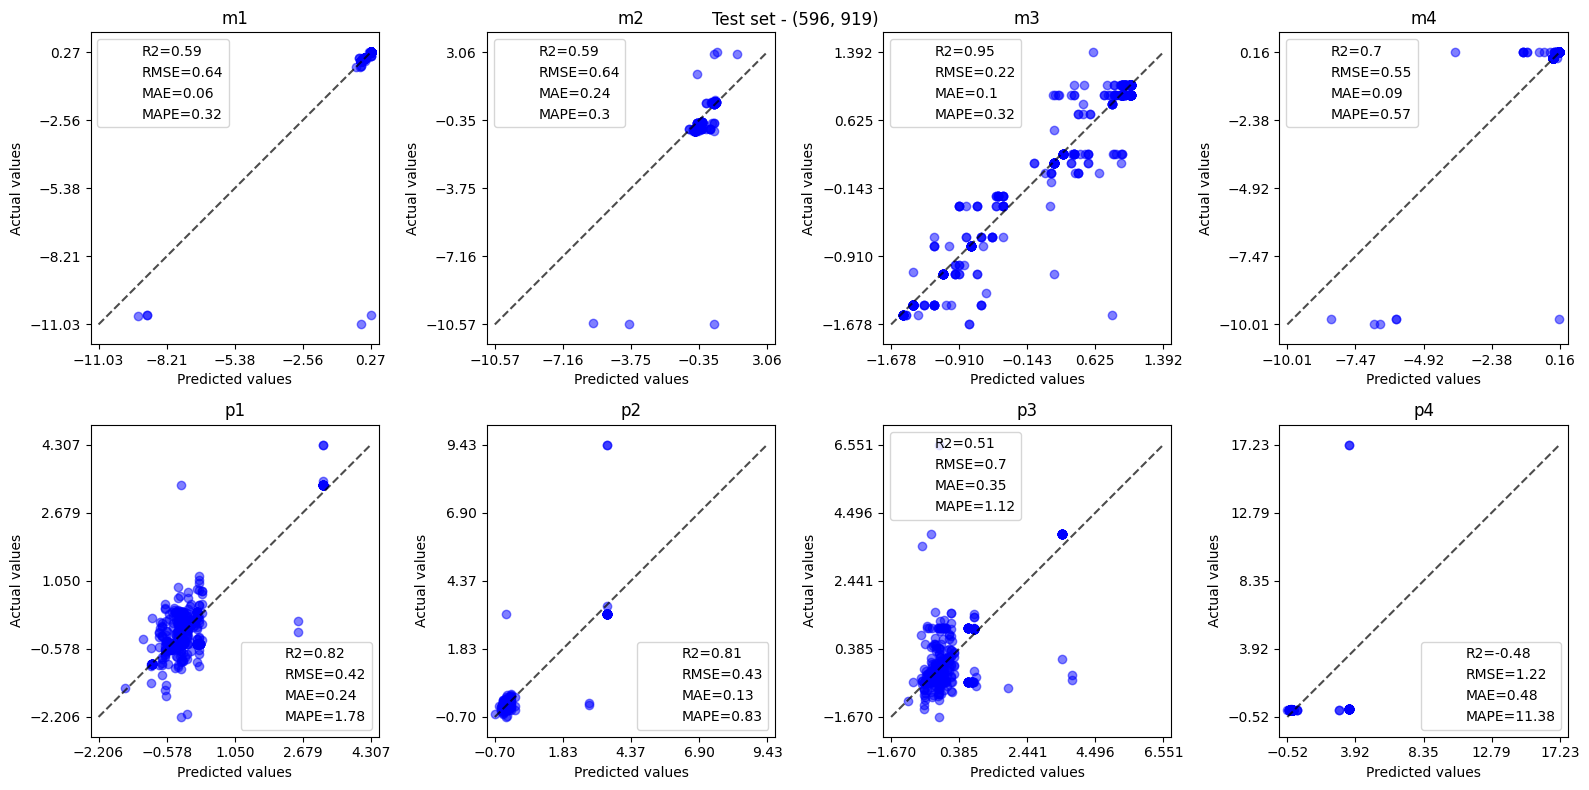


========== Metrics (test set)
RF score=0.56 
R2= 0.5621184114498604
MSE= 0.43788158855013826
RMSE= 0.6617262187265502
MAE= 0.21354683808991903
MAPE= 2.0785788503154854

Elapsed time: 3.1389450829010457 seconds



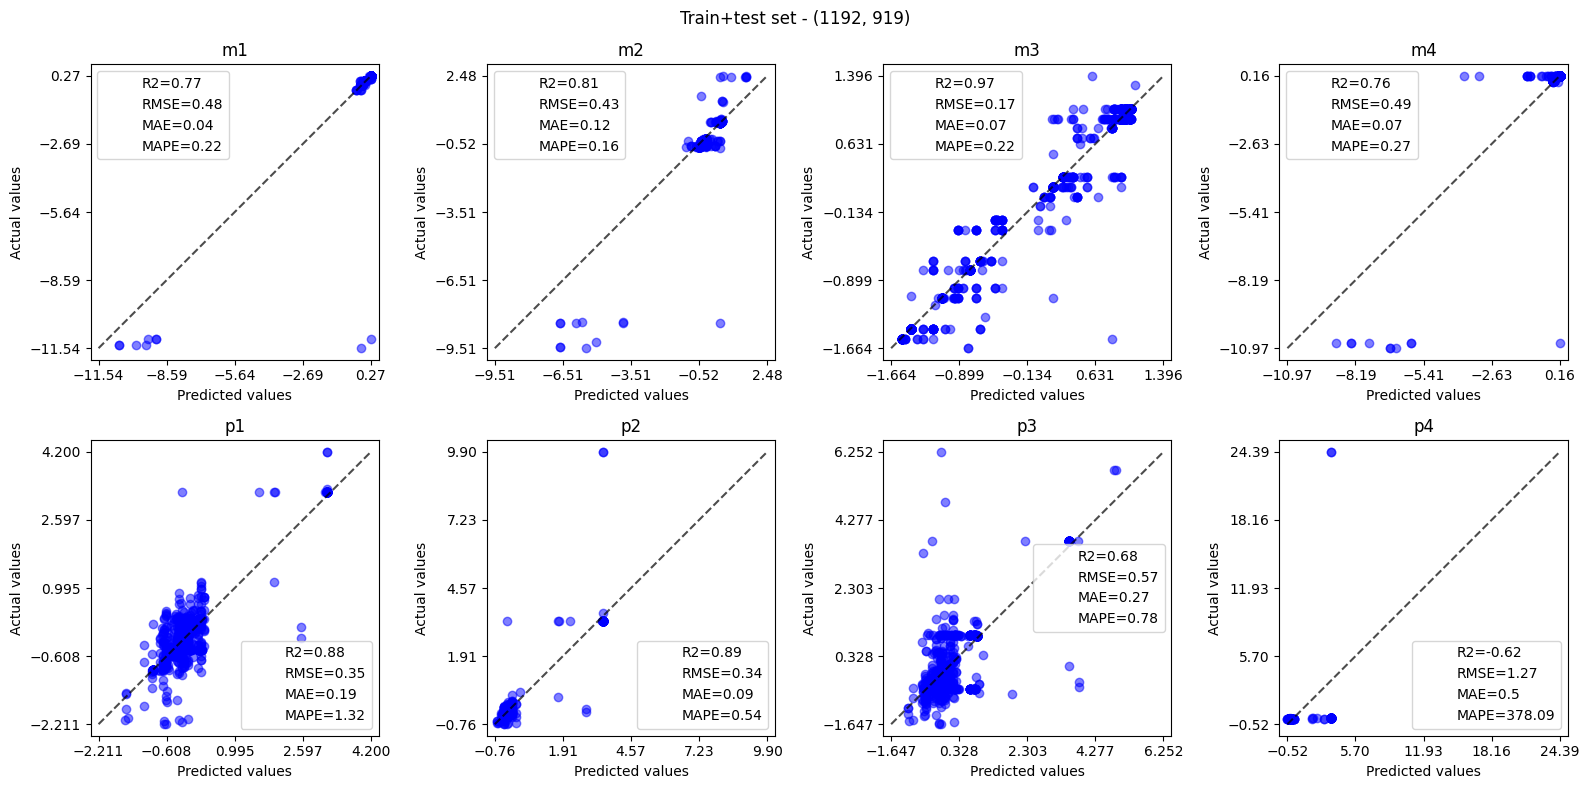


========== Metrics (whole set)
R2= 0.6411449623358214
MSE= 0.3588550376641786
RMSE= 0.5990451048662184
MAE= 0.16900872743427048
MAPE= 47.70101389665597
Standard scaling y ... 5 batches
kfolds: 2 ( 125 instances)
kfolds: 3 ( 344 instances)
kfolds: 3 ( 301 instances)
kfolds: 2 ( 120 instances)
kfolds: 3 ( 302 instances)


,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,596,919,0.562118,0.437882,0.661726,0.213547,2.078579,3.138945
1,naive - whole set,1192,919,0.641145,0.358855,0.599045,0.169009,47.701014,3.138945


In [531]:
print("COCOME - tactics & embeddings")
target = OBJ_COCOME
X, y, fnames = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=False)
print(X.shape, y.shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', refresh_leaf=True, process_type='default') #, update='refresh')
regressor = regr_rf # regr_rf # regr_xgb

metrics, y_pred_baseline_cocome = run_single_batch(X, y, regressor, show_plots=(2,4), target=target, verbose=False,
                                                   test_size=0.5, filename='cocome-naive-all.pdf', levels=df_cocome['level'])

X_batches, y_batches, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=True)
model_performance_dict['COCOME - t & e'] = run_cross_validation(regressor, X_batches, y_batches, metrics=scoring_metrics, cv_nfold=cv_nfold)

df_baseline_cocome = pd.DataFrame(metrics)
df_baseline_cocome

Target: m1


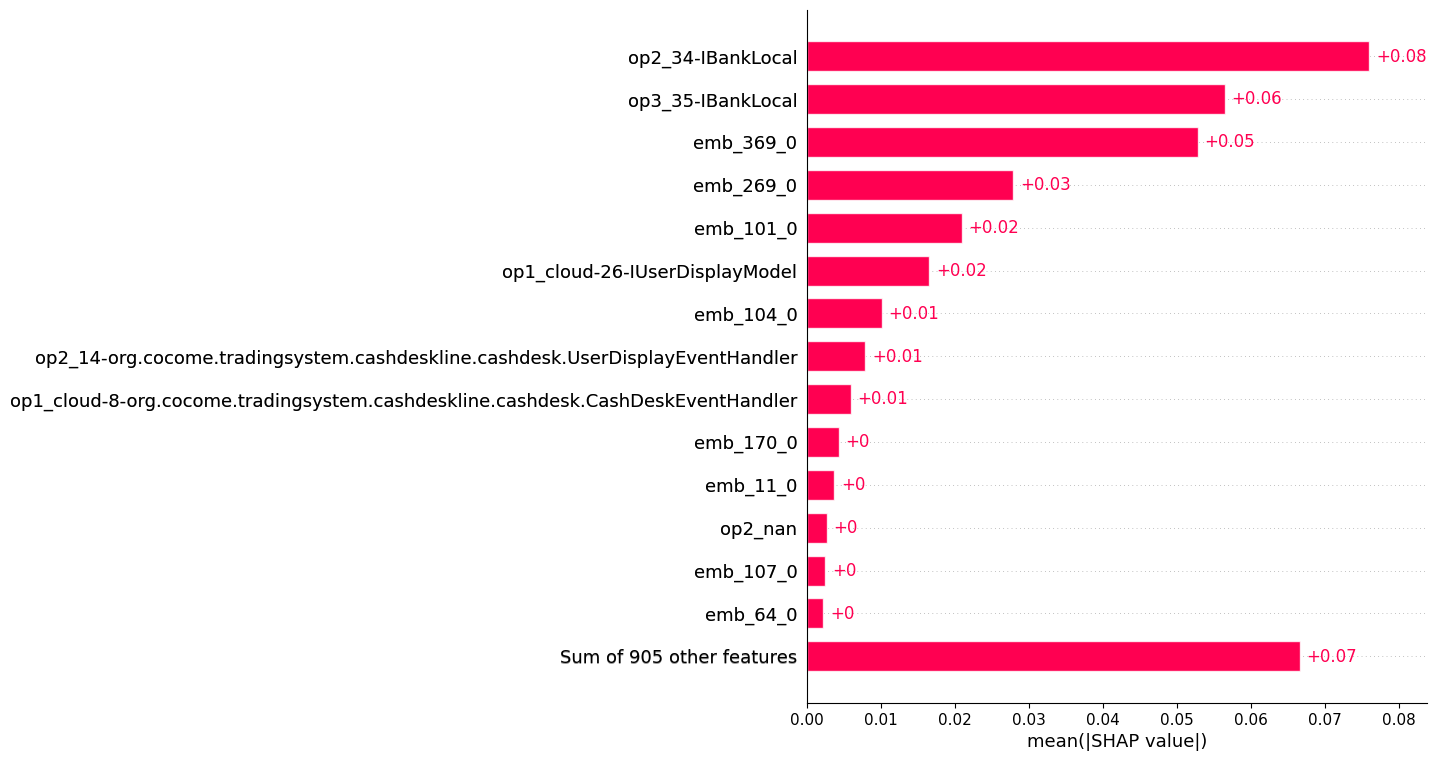

Target: m2


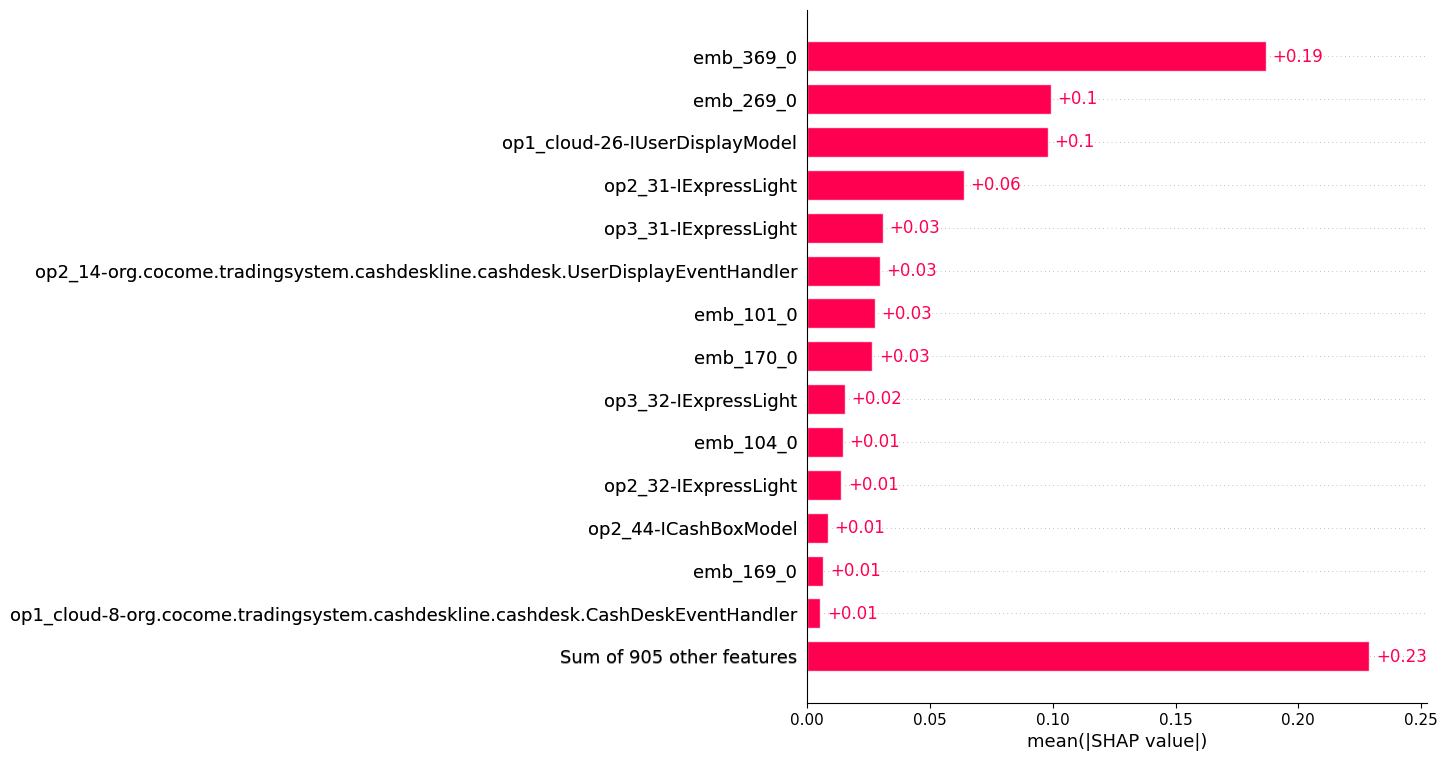

Target: m3


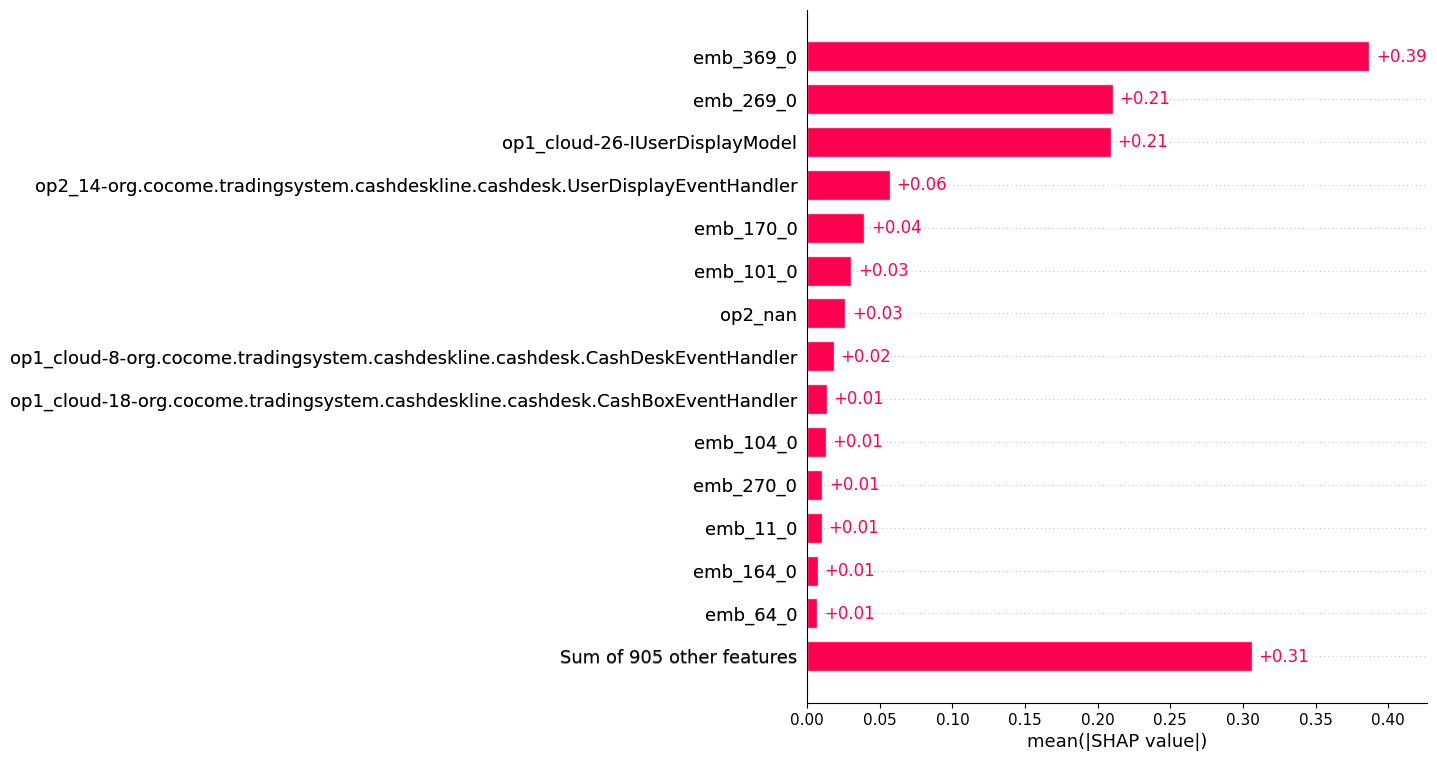

Target: m4


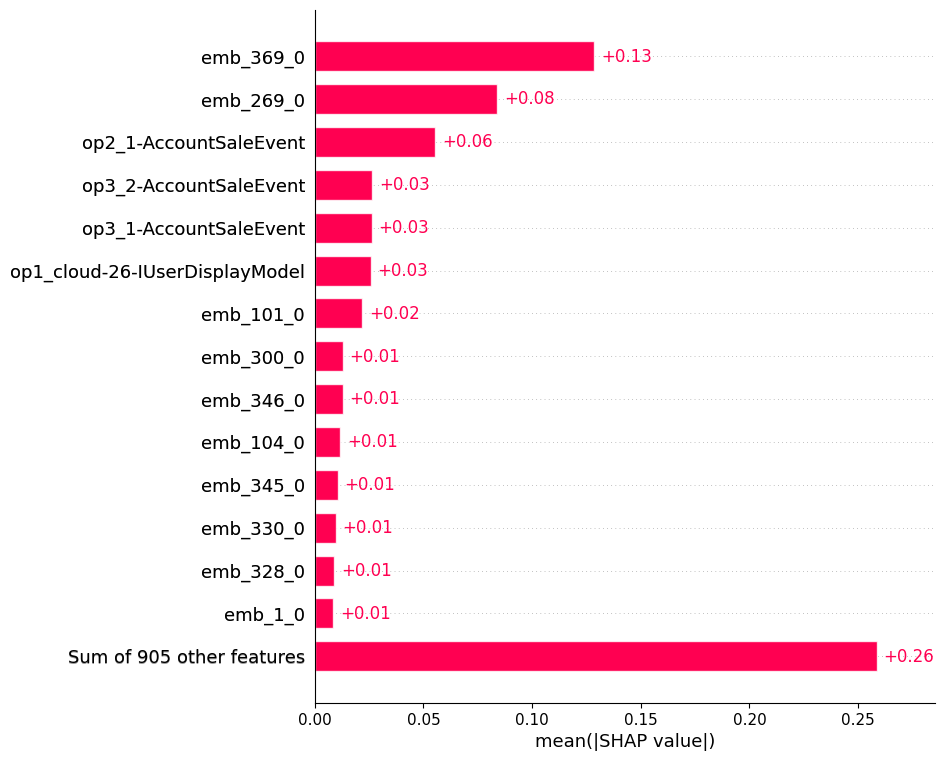

Target: p1


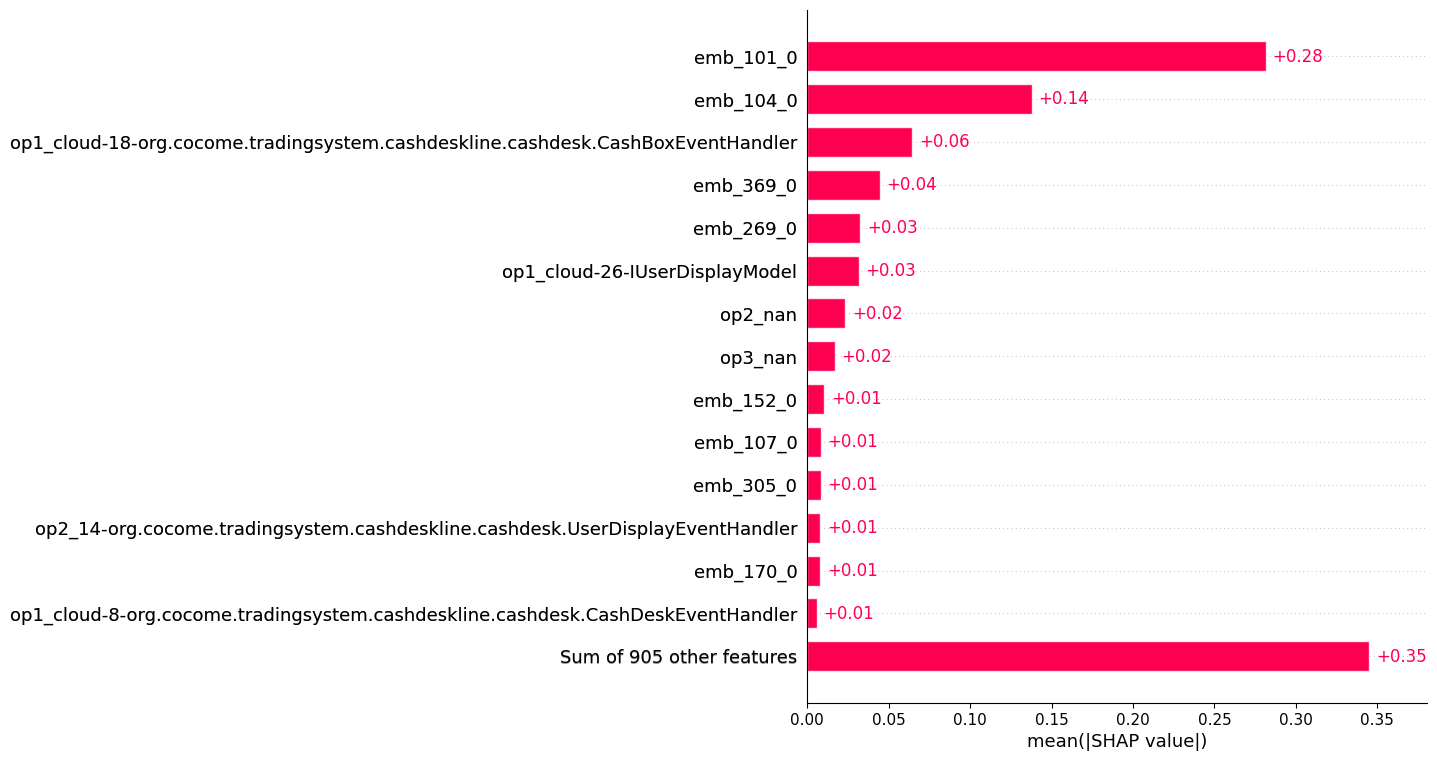

Target: p2


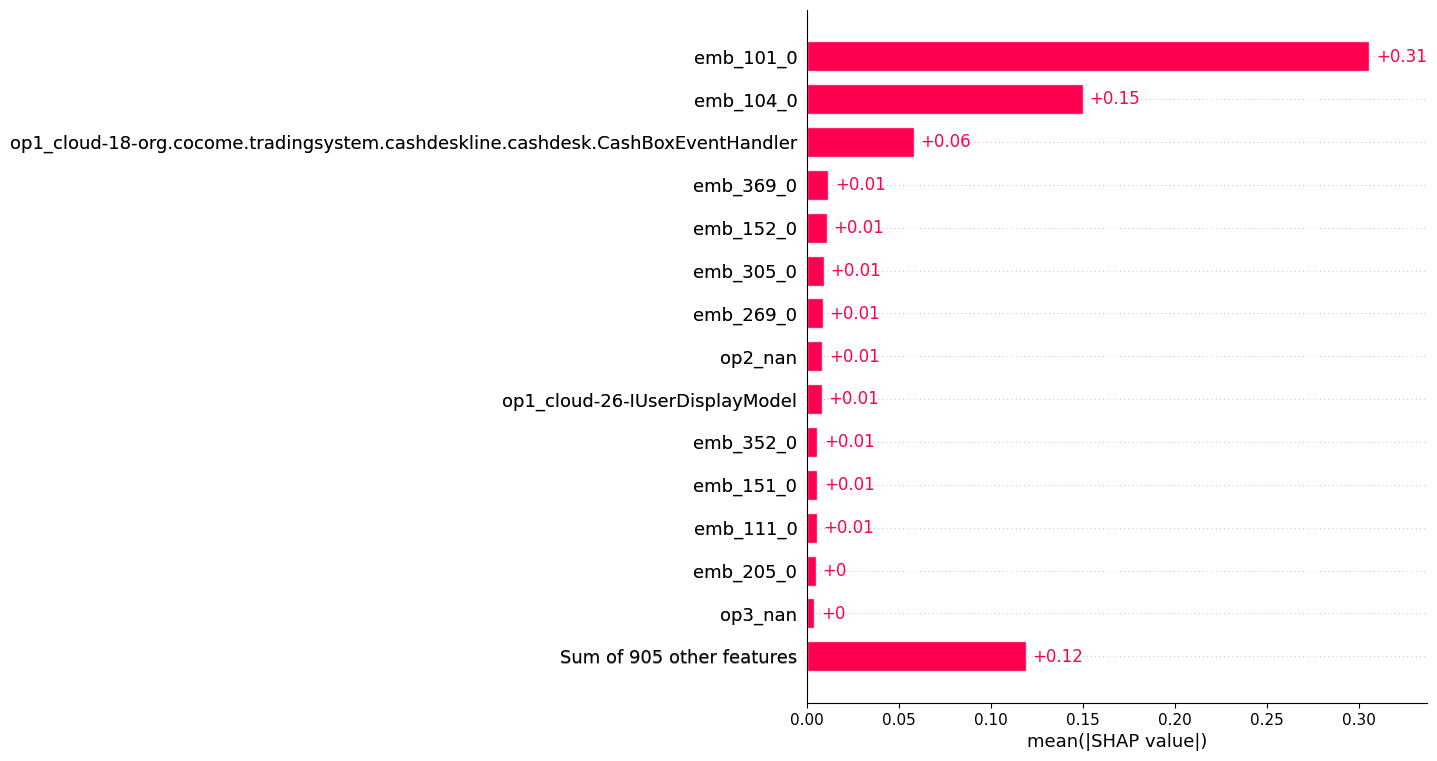

Target: p3


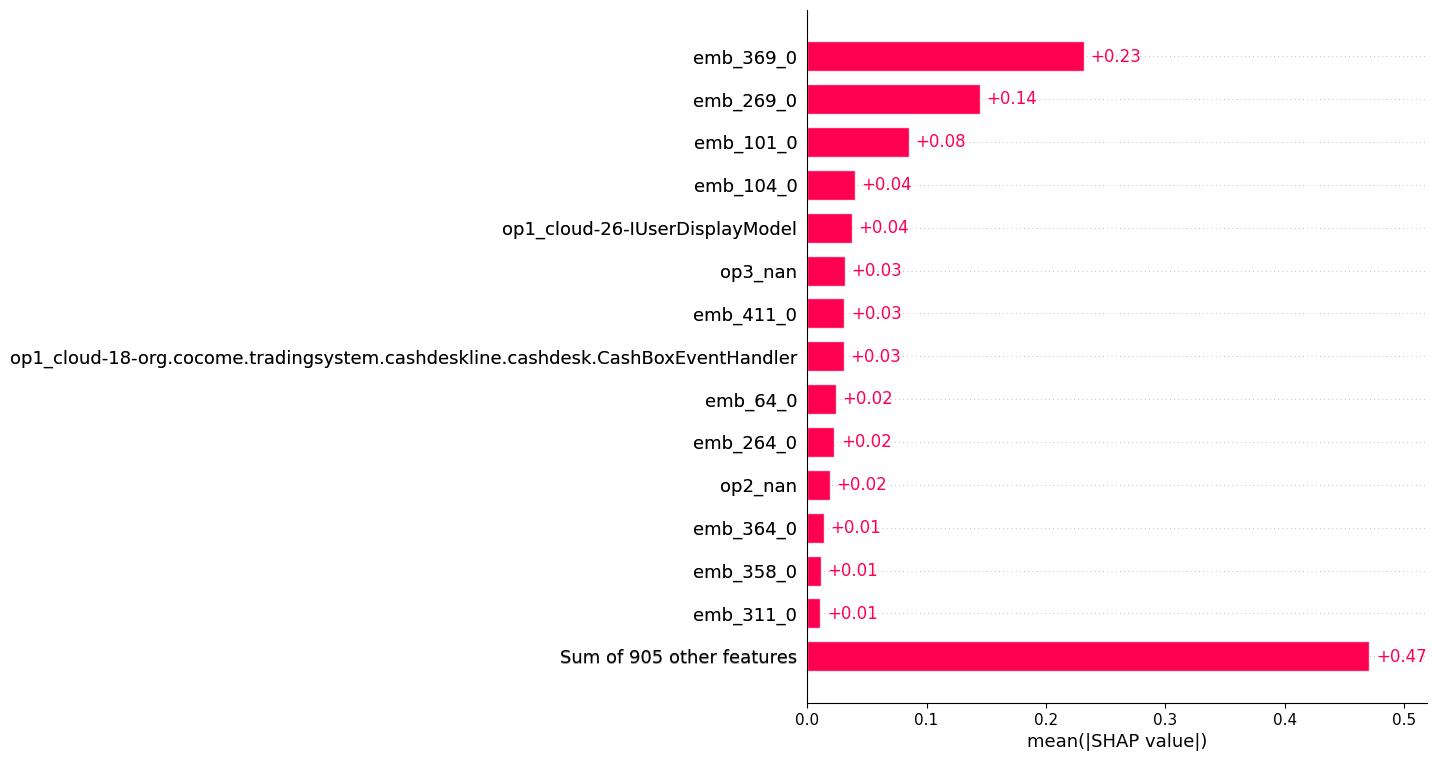

Target: p4


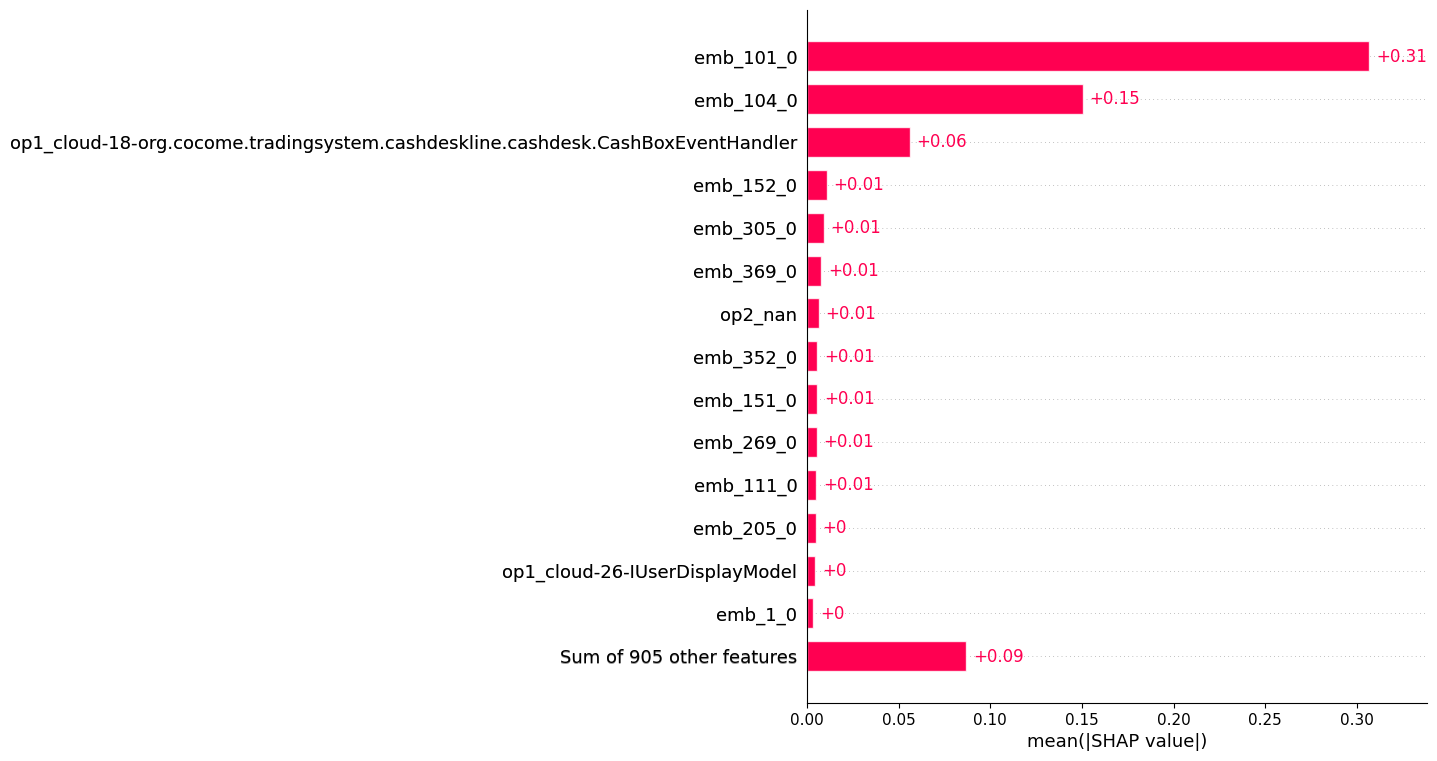

In [532]:
# Show influence of tactics and embeddings using SHAP values/plots
show_shap_plots(X, fnames, regressor, OBJ_COCOME)

In [533]:
scaled_stplus_df.to_csv('scaled_stplus.csv', index=False)
scaled_cocome_df.to_csv('scaled_cocome.csv', index=False)

In [534]:
baseline_preds_stplus_df = pd.DataFrame(data=y_pred_baseline_stplus, columns=scaled_stplus_df.columns)
baseline_preds_cocome_df = pd.DataFrame(data=y_pred_baseline_cocome, columns=scaled_cocome_df.columns)

In [535]:
baseline_preds_stplus_df.to_csv('baseline_preds_naive_stplus.csv', index=False)
baseline_preds_cocome_df.to_csv('baseline_preds_naive_cocome.csv', index=False)

In [536]:
df_baseline_stplus.to_csv('baseline_stplus.csv', index=False)
df_baseline_cocome.to_csv('baseline_cocome.csv', index=False)

---

In [537]:
# Get all the CV metrics for model ranking
# model_performance_dict

dicts_list = []
df_cols = []
for variant in model_performance_dict.keys():
    variant_dict = model_performance_dict[variant]
    for scoring_metric in variant_dict.keys():
        #print(variant, scoring_metric)
        df_cols.append(variant+" - "+scoring_metric)
        dicts_list.append(variant_dict[scoring_metric])
df = pd.DataFrame(dicts_list, index=df_cols).T
# outfilename = 'naive_performance_xgboost_'+str(cv_nfold)+'nfold.csv'
outfilename = 'naive_performance_rforest_'+str(cv_nfold)+'nfold.csv'
print("Saving to ...", outfilename)
df.to_csv(outfilename, index=False)
df

Saving to ... naive_performance_rforest_100nfold.csv


,STPLUS - t - neg_median_absolute_error,STPLUS - t - r2,STPLUS - t - neg_root_mean_squared_error,STPLUS - e - neg_median_absolute_error,STPLUS - e - r2,STPLUS - e - neg_root_mean_squared_error,STPLUS - t & e - neg_median_absolute_error,STPLUS - t & e - r2,STPLUS - t & e - neg_root_mean_squared_error,COCOME - t - neg_median_absolute_error,COCOME - t - r2,COCOME - t - neg_root_mean_squared_error,COCOME - e - neg_median_absolute_error,COCOME - e - r2,COCOME - e - neg_root_mean_squared_error,COCOME - t & e - neg_median_absolute_error,COCOME - t & e - r2,COCOME - t & e - neg_root_mean_squared_error
0,-0.626978,-1.444130,-1.014051,-0.639690,-14.634598,-0.769442,-0.322713,-1.247595,-0.590569,-0.873550,-1.126157e+30,-0.867086,-0.430454,-6.997440e+31,-0.447673,-4.284767e-16,-1.861257e+24,-0.047342
1,-0.832360,-0.480326,-1.324262,-0.194953,0.262271,-0.948398,-0.174351,0.304864,-0.913561,-0.659501,-4.204547e-01,-1.505470,-0.417109,1.297332e-01,-1.221601,-4.284204e-01,9.063295e-02,-1.247839
2,-0.208976,0.231643,-0.465446,-0.304985,-36.388741,-0.815246,-0.191265,-0.255336,-0.497150,-0.013025,5.231517e-01,-0.185288,-0.058114,-6.907402e-01,-0.208499,-3.883985e-02,5.595282e-01,-0.184639
3,-0.079428,0.527714,-0.483276,-0.333963,-0.454705,-0.797733,-0.093824,0.499614,-0.451352,-0.214668,3.536001e-01,-0.841868,-0.234813,-8.672214e+00,-1.062638,-2.034709e-01,3.086082e-01,-0.865105
4,-0.125477,0.509166,-0.602550,-0.328072,0.283677,-0.800774,-0.138201,0.549270,-0.551088,-0.445143,2.269029e-01,-1.087747,-0.405248,-1.297172e+00,-1.233254,-4.145321e-01,1.284094e-01,-1.148818
5,-0.120227,0.517221,-0.799328,-0.430931,0.325156,-0.950688,-0.136956,0.578888,-0.725799,-0.140232,-1.491762e+02,-0.581505,-0.605066,-1.543148e+04,-0.661597,-1.343320e-01,-2.220593e+01,-0.325989
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.537531,-5.262594e+00,-0.821884,-0.045843,-1.048919e+01,-0.937048,-1.073794e-15,-2.197945e+00,-0.596918
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.571843,-1.095256e+00,-1.372750,-0.549909,-6.754751e-01,-1.492300,-4.647568e-01,-6.206655e-01,-1.478834
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.317545,5.125856e-01,-0.499809,-0.294515,5.088625e-01,-0.542903,-2.901749e-01,5.110568e-01,-0.537064
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.309862,4.812609e-01,-0.566170,-0.272486,4.751562e-01,-0.576541,-2.742552e-01,4.737967e-01,-0.577560
